# The Quasi static step
In slippy loading, sliding and unloading can all be defined (in any combination) by using a Quasi static step. This step will move the surfaces relative to each other but the stress analysis will not take dynamic effects into account (hence quasi static). Other tangential behaviour can be solved through the use of submodels for tangential contact (e.g. rolling sliding behaviour). These steps can be eihter load or displacement controlled. Additionally both the load and the off set can be specified to ramp up as for oblique impacts.

After each time step any submodels will also be solved and all requested outputs will be written to file allowing for long term wear/ chemical modelling to be mixed into the solution of the contact mechanics problem.

---

In this basic example we will create a quasi static step that solves normal contact between a ball and a flat, however these surfaces could be any rought surfaces. At the end of each time step we will use a sub model to measure the contact stiffness of the contact in both the loading and unloading direction. We will also limit the contact pressure to a specified hardness value, this can be used as the simplest method to account for plastic effects.

To make this model we must complete the folling steps:
- Import slippy
- Generate the geometry of our surfaces
- Set the materials for our surfaces
- Make a contact model
- Add a quasi static step to the contact model
- Add the contact stiffness sub model to the quasi static step
- Solve the model
- Plot the results

---

#### NOTE: If you do not have CUDA set up this notebook will take a long time to run, if this is a problem change the domain size by changing n for 1024 to 256 in the cell below

---
We will start by importing everything we need:

In [2]:
# Change n here to reduce the domain size, 256 should be appropriate for non CUDA systems.
n = 1024
import slippy.surface as s
import slippy.contact as c
%matplotlib inline

## Making the geometry of the surfaces
Next we will make one round and one flat surface, we will descretise the round surface, this will be our primary surface. The primary surface must always be descretised. The flat surface dosn't need to be descretised as it is analytically defined. However, if wear or other processes are required to be kept track of on the secondary surface it must be descretised as it will no longer be analytically defined after these processes have taken effect.

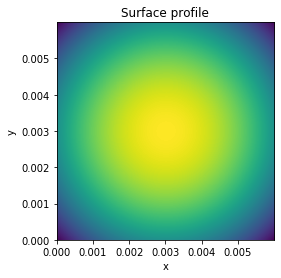

In [3]:
flat_surface = s.FlatSurface(shift=(0,0))
round_surface = s.RoundSurface((1,1,1), extent = (0.006, 0.006), 
                               shape = (n, n), generate = True)
round_surface.show()

## Setting the materials
Next we will set the materials for each surface. In this example we will use steel for the round surface and aluminum for the flat surface, we will set the maximum allowable pressure on the aluminum material to 3e7 Pa (Which is obviously way too low but good for an example).

In [4]:
steel = c.Elastic('Steel', {'E': 200e9, 'v':0.3})
aluminum = c.Elastic('Aluminum', {'E': 70e9, 'v':0.33}, max_load = 3.0e7)
flat_surface.material = aluminum
round_surface.material = steel

## Making a contact model
Next we will make a contact model object, this contains all the information needed to solve the contact, everything that you want the programto do must be put in this object or it will not get solved when the model is solved.

In [5]:
my_model = c.ContactModel('model-1', round_surface, flat_surface)

## Making a quasi static step and adding it to the model
Now we will make a QuasiStaticStep and add it to the model. In this example, we will set the start and end points of the total normal load, and request 50 time steps where the load will ramp between these values. This simulates gradual indentation of a ball into the surface. As the actual solutions are static, this process is also time independent, this means we can specify the 'not_time' keyword to True. This will speed up the solution of the step, however, if there are time dependent sub models (eg visco elasticity, wear etc.) this will cause them to fail, this step may also not converge for all time points and the results will be incorrect.

The QuasiStaticStep also allows the user to specify paths for the surfaces for relative motion, or more complicated loading functions. These are controlled by provided a table of values to the: off_set_x, off_set_y, interference or normal_load arguments. These tables should be a 2 by n array of position/ load values and relative time points. The relative time points must all be between 0 and 1. The total duration of the quasi static step can also be set, the duration of the individual time steps will be calculated from this and the number of time steps requested. 

In [6]:
max_load = 100
my_step = c.QuasiStaticStep('contact', 10, no_time=True, normal_load = [1, max_load])
my_model.add_step(my_step)
my_model.steps

OrderedDict([('Initial', InitialStep(model = None, name = initial)),
             ('contact', contact: QuasiStaticStep)])

## Probably just ignore this
In this section we will make a hacky sub model to save our data, this is because I haven't sorted the outputs at the time of writing, hopefully this isn't necessary by the time you read it.

In [7]:
from slippy.abcs import _SubModelABC

class SavingSubModel(_SubModelABC):
    def __init__(self, name, vars_to_save):
        super().__init__(name)
        self.vars_to_save = vars_to_save
        for var in vars_to_save:
            self.__setattr__(var, [])
        
    def solve(self, current_state):
        for var in self.vars_to_save:
            self.__getattribute__(var).append(current_state[var])
        return dict()

## Adding a sub model
Now we will make a contact stiffness model and add it to the model step. Note that sub models will be run in the order that they are added.

In [8]:
cs_sub_model = c.sub_models.ContactStiffness('Stiffness')

sub_model = SavingSubModel('sub_1', ['interference', 'total_normal_load',
                                     's_contact_stiffness_loading_z',
                                     's_contact_stiffness_unloading_z', 
                                     'total_plastic_deformation'])

wear_submodel = c.sub_models.EPPWear('wear', 1)

my_step.add_sub_model(cs_sub_model)
my_step.add_sub_model(wear_submodel)
my_step.add_sub_model(sub_model)

## Solving the contact model
We are now ready to solve the contact model, this is very simple:

In [9]:
results = my_model.solve()

C:\Users\mea08\code\SlipPY\slippy\contact\influence_matrix_utils.py:585: UserWarning: Bound constrained conjugate gradient iterations failed to converge
  warnings.warn("Bound constrained conjugate gradient iterations failed to converge")


## Plotting the results
In this section we will plot the results, comparing to the hertz solution, for this we will need to import a plotting library and generate the analytical hertz soltuons for each time step.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
interference = sub_model.interference
load = sub_model.total_normal_load
cs_l = sub_model.s_contact_stiffness_loading_z
cs_u = sub_model.s_contact_stiffness_unloading_z

In [14]:
analytical_solution = c.solve_hertz_point(r_rel = 1, e1= 200e9, e2= 70e9, v1= 0.3, v2 = 0.33, 
                                          load = np.array(load))
a_disp = analytical_solution.total_displacement

We can see extremely good agreement between the analytical solution and the numerical solution in the elastic region of the contact, when the contact becomes plastic the results deviate as expected.

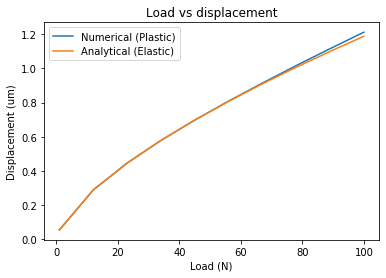

In [15]:
plt.plot(load, np.array(interference)*1e6, label='Numerical (Plastic)')
plt.plot(load, a_disp*1e6, label='Analytical (Elastic)')
plt.title('Load vs displacement')
plt.xlabel('Load (N)')
plt.ylabel('Displacement (um)')
plt.legend()

We can also see the contact stiffness of the contact increases as a larger area comes into contact. As some of the points in contact turm plastic, the stiffness in the loading direction decreases, while it continues to increase in the unloading direction.

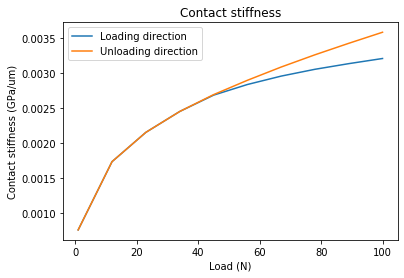

In [16]:
plt.plot(load, np.array(cs_l)/1e15, label = 'Loading direction')
plt.plot(load, np.array(cs_u)/1e15, label = 'Unloading direction')
plt.title('Contact stiffness')
plt.xlabel('Load (N)')
plt.ylabel('Contact stiffness (GPa/um)')
plt.legend()

## Showing the deformation

In the remainder of this note book we will plot out the profiles of the surfaces so we can seen what permanent changes the plastic deformation has made. 

---
Firstly, we can show the deformed surface side by side with the unworn surface, note that this will work for any source of wear.

C:\Users\mea08\code\SlipPY\slippy\surface\Surface_class.py:960: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 720x288 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x19753c54508>])

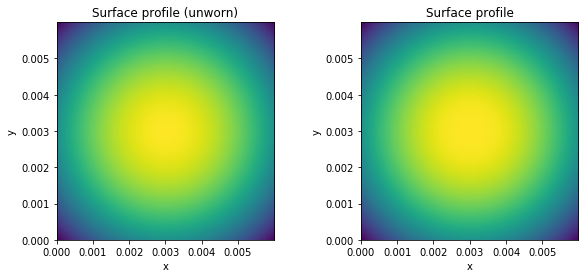

In [17]:
round_surface.show(['unworn_profile', 'profile'], ['image'], figsize = (10,4))

We can also access the profile directly to make line plots which may be more appropriate for visual comparison.

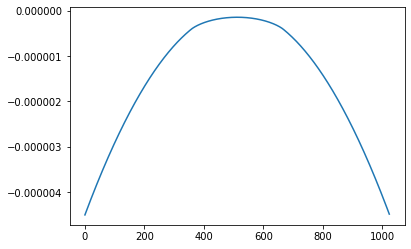

In [18]:
plt.plot(round_surface.profile[n//2])

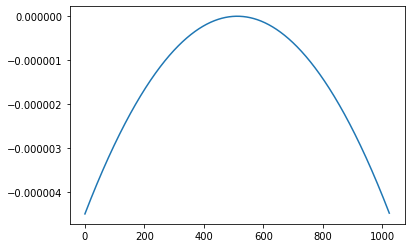

In [19]:
plt.plot(round_surface.unworn_profile[n//2])

We can also plot just the wear caused by a particular wear model, in this case we jsut have one wear model called 'wear':

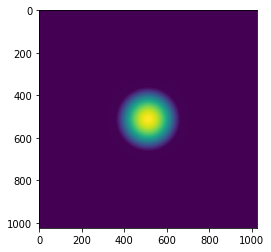

In [29]:
plt.imshow(round_surface.wear_volumes['wear'])

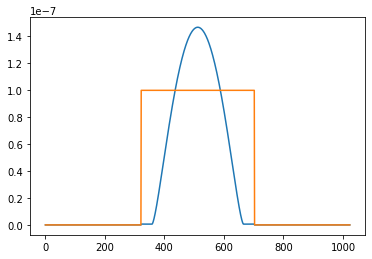

In [30]:
plt.plot(round_surface.wear_volumes['wear'][n//2])
plt.plot(0.0000001*results['contact_nodes'][n//2])

We can also plot which areas of the surfaces are in contact:

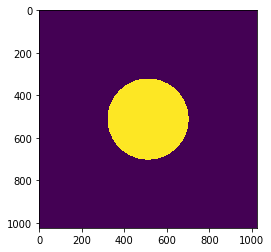

In [31]:
plt.imshow(results['contact_nodes'])

Through using the saving sub model we can plot the total plastic deformation for the contact during the loading step:

Text(0, 0.5, 'Plastic wear $(m^{3})$')

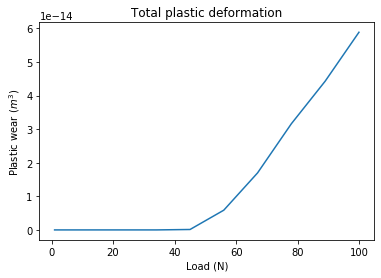

In [40]:
tpd = sub_model.total_plastic_deformation
plt.plot(load, tpd)
plt.title('Total plastic deformation')
plt.xlabel('Load (N)')
plt.ylabel('Plastic wear $(m^{3})$')

Lastly, we can plot the original profile, the profile under load fo the highest load and the shape of the unloaded profile after the loading process:

Text(0, 0.5, 'Profile height (m)')

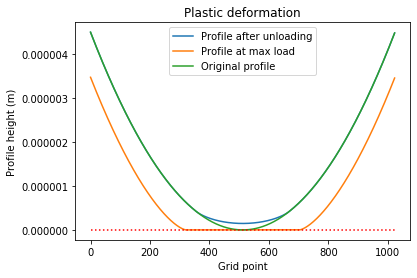

In [34]:
jtg, _, _ = c._model_utils.get_gap_from_model(my_model, 0, (0,0))
gap3 = jtg - results['interference'] + results['total_displacement'].z
plastic_def = jtg[n//2][0]+round_surface.unworn_profile[n//2][0]
plt.plot(jtg[n//2]-plastic_def, label = 'Profile after unloading')
plt.plot(gap3[n//2]-np.min(gap3[n//2]), label = 'Profile at max load')
plt.plot(-round_surface.unworn_profile[n//2], label = 'Original profile')
plt.plot([0,n], [0,0], 'r:')
plt.legend()
plt.title('Plastic deformation')
plt.xlabel('Grid point')
plt.ylabel('Profile height (m)')